In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr, kendalltau, spearmanr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Carrega a base de média diária de voos

In [2]:
international_flights_avg = pd.read_csv('jan-media_voos.csv')
international_flights_avg = international_flights_avg[['org', 'dest', 'valor_norm']]
international_flights_avg = international_flights_avg.rename(columns={'org': 'source', 'dest': 'target', 'valor_norm':'value'})

In [3]:
international_flights_avg.head()

,source,target,value
0,Algeria,Austria,1.000000
1,Algeria,Belgium,1.275510
2,Algeria,Canada,1.000000
3,Algeria,France,12.272727
4,Algeria,Germany,1.560345


Constrói o grafo com a probabilidade de voos entre países

In [4]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()

transition_matrix = transition_matrix.set_index('source').join(country_international_flights, lsuffix='_daily_flights', rsuffix='_source_sum_flights')

transition_matrix['prob'] = (transition_matrix['value_daily_flights']/transition_matrix['value_source_sum_flights'])
transition_matrix = transition_matrix.drop(columns=['value_source_sum_flights', 'value_daily_flights']).reset_index()

In [5]:
transition_matrix.head()

,source,target,prob
0,Algeria,Austria,0.027296
1,Algeria,Belgium,0.034816
2,Algeria,Canada,0.027296
3,Algeria,France,0.334996
4,Algeria,Germany,0.042591


In [6]:
transition_matrix.groupby('source')[['prob']].sum()

,prob
source,
Algeria,1.0
Argentina,1.0
Armenia,1.0
Australia,1.0
Austria,1.0
Bahrain,1.0
Bangladesh,1.0
Barbados,1.0
Belarus,1.0


Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [7]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])

In [8]:
countries = transition_matrix['source'].unique()

def get_cases(day=77):
    cases = total_cases.xs(day, level=1).reindex(countries).fillna(0)

    cases = cases.rename(columns={'Total': 'n_cases'}) 
    return cases

daily_cases = get_cases()


In [9]:
#TODO: os nomes das df de voos e  casos parecem estar muito diferentes. eh preciso normaliza-los... veja que tem muito valor nulo no votor abaixo 

state_df_start = total_cases.xs(0, level=1).reindex(transition_matrix['source'].unique())
state_df_start = state_df_start.fillna(0)

state_df_start

,Total
Name,
Algeria,0.0
Argentina,0.0
Armenia,0.0
Australia,0.0
Austria,0.0
Bahrain,0.0
Bangladesh,0.0
Barbados,0.0
Belarus,0.0


Faz o random walk

In [10]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

transition_matrix_crosstab

source,Algeria,Argentina,Armenia,Australia,Austria,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Bolivia,Brazil,Canada,China,Colombia,Costa Rica,Croatia,Czech Republic,Denmark,Dominican Republic,Estonia,Finland,France,French Polynesia,Germany,Greece,Hong Kong,Hungary,Iceland,India,Indonesia,Ireland,Israel,Italy,Japan,Kazakhstan,Latvia,Luxembourg,Macau,Malaysia,Malta,Mexico,Morocco,Netherlands,New Zealand,Norway,Philippines,Poland,Portugal,Puerto Rico,Qatar,Romania,Russia,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,South Africa,South Korea,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Algeria,0.000000,0.000000,0.000000,0.000000,0.004250,0.000000,0.000000,0.000000,0.000000,0.006687,0.000000,0.000000,0.002777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025509,0.000000,0.001866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025101,0.000000,0.000000,0.000000,0.000000,0.000000,0.004624,0.000000,0.007190,0.000000,0.003975,0.000000,0.048590,0.000000,0.000000,0.000000,0.000000,0.000000,0.010009,0.000000,0.000000,0.003640,0.000000,0.005439,0.009539,0.012517,0.005355,0.001589,0.000000
Argentina,0.000000,0.000000,0.000000,0.008534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.177257,0.166737,0.003240,0.000000,0.042439,0.025858,0.000000,0.000000,0.000000,0.029706,0.000000,0.000000,0.002189,0.000000,0.001196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036066,0.000000,0.003177,0.018676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009649,0.000000,0.000000,0.003114,0.000000,0.000000,0.000000,0.000000,0.000000,0.001767,0.008906
Armenia,0.000000,0.000000,0.000000,0.000000,0.004315,0.000000,0.000000,0.000000,0.019829,0.005243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008270,0.000000,0.000000,0.000000,0.000000,0.002079,0.000000,0.001595,0.011791,0.000000,0.000000,0.000000,0.000000,0.000000,0.005008,0.010360,0.004159,0.000000,0.025038,0.012027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004133,0.000000,0.000000,0.007502,0.014668,0.043145,0.000000,0.000000,0.019190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005425,0.003114,0.000000,0.000000,0.000000,0.015762,0.006817,0.000000,0.000000
Australia,0.000000,0.028766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012280,0.007297,0.031858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002425,0.150901,0.001196,0.000000,0.052383,0.000000,0.000000,0.006693,0.087172,0.000000,0.000000,0.002189,0.025863,0.000000,0.000000,0.000000,0.030262,0.084649,0.000000,0.000000,0.000000,0.000000,0.548233,0.000000,0.046318,0.000000,0.000000,0.000000,0.032173,0.000000,0.003975,0.015990,0.000000,0.000000,0.113104,0.000000,0.029597,0.018758,0.000000,0.019296,0.005425,0.000000,0.019057,0.033699,0.000000,0.000000,0.024429,0.001623,0.019342
Austria,0.027296,0.000000,0.030621,0.000000,0.000000,0.000000,0.037372,0.000000,0.027355,0.021342,0.000000,0.000000,0.004240,0.015676,0.000000,0.000000,0.070286,0.023961,0.033894,0.000000,0.036947,0.017580,0.019667,0.000000,0.060550,0.037288,0.005091,0.020045,0.025005,0.005383,0.000000,0.011018,0.042807,0.026200,0.007456,0.000000,0.025827,0.039477,0.000000,0.000000,0.023308,0.000000,0.019396,0.036179,0.000000,0.023137,0.000000,0.025292,0.016610,0.000000,0.013973,0.045755,0.031317,0.015990,0.000000,0.035181,0.000000,0.040901,0.030694,0.006800,0.022772,0.000000,0.026810,0.044119,0.009546,0.013526,0.030977,0.051560,0.010133,0.023859,0.003804
Bahrain,0.000000,0.00

In [11]:
state_df_start

,Total
Name,
Algeria,0.0
Argentina,0.0
Armenia,0.0
Australia,0.0
Austria,0.0
Bahrain,0.0
Bangladesh,0.0
Barbados,0.0
Belarus,0.0


In [12]:
transition_matrix = transition_matrix.set_index(['source', 'target'])

In [13]:
def transition_matrix_loss(loss_df):    
    df_joined = transition_matrix.join(loss_df, how='left')

    df_joined['prob'] = df_joined['prob']*df_joined['pct_loss']

    df_joined = df_joined.reset_index()

    df_joined = pd.crosstab(df_joined['target'], df_joined['source'], df_joined['prob'], aggfunc=sum)
    df_joined = df_joined.fillna(0)

    return df_joined

In [14]:
week_loss_df = pd.read_csv('data/week_pct_loss.csv').drop(columns=['Unnamed: 0']).rename(columns={'org': 'source', 'dest':'target'})

In [15]:
def model_spread2(r, p, use_loss=False, day=77):
    state_df = state_df_start
    
    for i in range(1, (day+1)):
        week = math.ceil(i/7)
        if(week<5):
            state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
        else:
            if use_loss:
                week_loss = week_loss_df.set_index(['week_value']).loc[week].reset_index().set_index(['source', 'target']).drop(columns=['week_value'])
                transition_matrix_week =transition_matrix_loss(week_loss)
                state_df = state_df*r + (transition_matrix_week.dot(state_df)*p)
            else:
                state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
            
            
    return state_df

In [16]:
def model_optimize(day=77, use_loss=False):
    cases = get_cases(day)
    # function we would like to fit
    func=lambda tpl : model_spread2(tpl[0], tpl[1], use_loss, day).T.values[0]
    # ErrorFunc is the diference between the func and the y "experimental" data
    ErrorFunc=lambda tpl,cases: func(tpl)-cases # np.sqrt(np.abs(func(tpl)-cases))
    #tplInitial contains the "first guess" of the parameters 
    tplInitial1=(1.001,0.0000001)
    # leastsq finds the set of parameters in the tuple tpl that minimizes
    # ErrorFunc=yfit-yExperimental
    tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(cases['n_cases'].values))
    print(" params ",tplFinal1)


    return pd.DataFrame({'CasesPredicted':func(tplFinal1)}, index=transition_matrix_crosstab.columns)


In [17]:
df_model_corr = pd.DataFrame({'Day':[], 'NoLoss':[], 'WithLoss':[]}).set_index('Day')

In [18]:
gap = 4 #para agilizar nos testes, usem valores maiores que 1

for d in range(30, 77, gap):
    state_df= model_optimize(day=d, use_loss=False)
    state_df_loss= model_optimize(day=d, use_loss=True)
    cases = get_cases(d)
    
    pearson_nl = pearsonr(state_df['CasesPredicted'].values, cases['n_cases'].values)
    spearman_nl = spearmanr(state_df['CasesPredicted'].values, cases['n_cases'].values)
    pearson_l = pearsonr(state_df_loss['CasesPredicted'].values, cases['n_cases'].values)
    spearman_l = spearmanr(state_df_loss['CasesPredicted'].values, cases['n_cases'].values)
    df_model_corr.loc[d, 'NoLoss'] = spearman_nl[0]
    df_model_corr.loc[d, 'WithLoss'] = spearman_l[0]
    print('==========', d, ' days ============')
    print('No loss ->', 'pearsonr: ', pearson_nl,
        '\n           ', 'spearmanr: ', spearman_nl)
    print('With loss ->', 'pearsonr: ', pearson_l,
        '\n           ', 'spearmanr: ', spearman_l)

(' params ', array([1.20753945e+00, 4.99388702e-04]))
(' params ', array([1.20753945e+00, 4.99388702e-04]))
('==========', 30, ' days ============')
('No loss ->', 'pearsonr: ', (0.999997727287327, 4.647797889579114e-186), '\n           ', 'spearmanr: ', SpearmanrResult(correlation=0.5959938077675054, pvalue=4.170385576845681e-08))
('With loss ->', 'pearsonr: ', (0.999997727287327, 4.647797889579114e-186), '\n           ', 'spearmanr: ', SpearmanrResult(correlation=0.5959938077675054, pvalue=4.170385576845681e-08))
(' params ', array([1.20915949e+00, 3.57846353e-04]))
(' params ', array([1.20915949e+00, 3.57846353e-04]))
('==========', 34, ' days ============')
('No loss ->', 'pearsonr: ', (0.9999988294199104, 5.324853966708343e-196), '\n           ', 'spearmanr: ', SpearmanrResult(correlation=0.662236139890438, pvalue=3.187628226917105e-10))
('With loss ->', 'pearsonr: ', (0.9999988294199104, 5.324853966708343e-196), '\n           ', 'spearmanr: ', SpearmanrResult(correlation=0.662236

In [19]:
df_model_corr

,NoLoss,WithLoss
Day,,
30.0,0.595994,0.595994
34.0,0.662236,0.662236
38.0,0.669705,0.661700
42.0,0.670881,0.663881
46.0,0.670435,0.659526
50.0,0.670190,0.658297
54.0,0.675303,0.674476
58.0,0.577903,0.594985
62.0,0.537987,0.540889


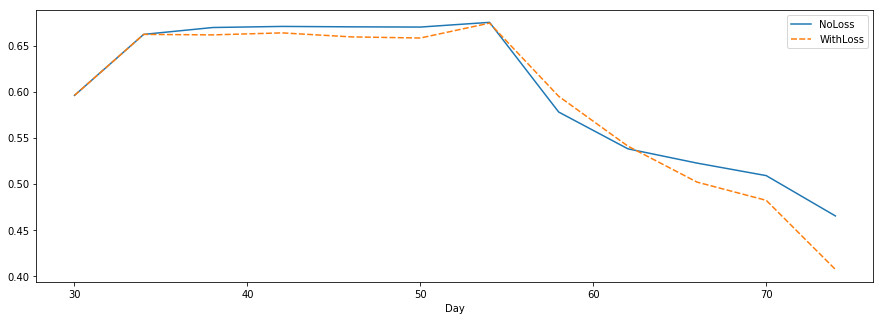

In [20]:
plt.figure(figsize=(15,5))

sns.lineplot(data=df_model_corr)

In [21]:
#state_df_final = model_spread2(r_min_dist, p)

#print(state_df_final.sum())

#state_df_final.sort_values('CasesPredicted', ascending=False)

In [22]:
#print(daily_cases.sum())

#daily_cases.sort_values('n_cases', ascending=False)

In [23]:
#pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])
#pearsonr(state_df_final['CasesPredicted'].values, daily_cases['n_cases'].values)

In [24]:
#daily_cases.rename_axis("source").index
#pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

In [25]:

#TODO: daily_cases tem tuplas como indice. ajustar la em cima para que o indice seja simplesmente o nome do pais (nao fazendo essa gambiarra que fiz mas sim usando o pandas do jeito certo para que isto nao aconteca)

#daily_cases.index = [x[0] for x in daily_cases.rename_axis("source").index]

#daily_cases['n_cases'] = daily_cases['n_cases'].astype(float)

#daily_cases

In [26]:
#df_results = state_df_final.join(daily_cases)

#df_results['Residuals'] = df_results['n_cases'] - df_results['CasesPredicted']

#df_results['ResidualsAbs'] = df_results['Residuals'].abs()

#df_results.sort_values('Residuals')

In [27]:
#df_results.corr()

In [28]:
#df_results.drop('China').corr()

In [29]:
#df_results.corr(method='kendall')

In [30]:
#df_results.drop('China').plot.scatter(x='CasesPredicted', y='n_cases')

In [31]:
#state_df_final.join(daily_cases).drop('China').corr(method='kendall')

In [32]:
#correlation_pivot = correlation_df.pivot(index='P', columns='R', values='Euclidean Distance')
#correlation_pivot

In [33]:
#heatmap = sns.heatmap(correlation_pivot.iloc[:,5:6], annot=True)